# 1 Author

**Student Name**:  Shabnam Khodadadi

**Student ID**:  210936704



# 2 Problem formulation
We want to predict the name of the song for each hum/whistle audio file, It is so interesting as all of us have experience of humming/whistling a song and we don't know the name of the song so we cant search it on the internet and download it, it just stuck in our head all day long because we have heard it somewhere in the past but we don't know the name of it. our problem is multi-class supervised classification as we have 8 different labels and a dataset of hum/whistle audio files which has labels already.

# 3 Machine Learning pipeline
1.   Collecting the data
, we collected the audio files which are recorded by a person humming/whistling the 8 different songs.
- analyzing data, this step is already done in starter kit so we dont have it here
2.   Preprocessing data
, we have a structure for naming the files but some people do typos in naming the files, as we need the file names to distinguish the audio file label(song name) so we need to convert it to the right format, this process is done in preprocess_file_names function, the input is the name of our files and the output is the data frame which consists of correct file_name as an index and some information as like as song name which is extracted from the formatted filename
3.   Feature selection, the input is a raw audio signal which is consisting of hundreds of thousands of dimensions, the output is a NumPy array that consist of 5 float value features, and an int value label
4.   Feature normalization, Since the range of values of raw data, varies widely we normalize the data by standard deviation and mean, the input is our features and the output is the normalized features
5. Split the data, we split the data to train and validate in order to train and validate our models, the input is the array of samples with features and the labels array
6. Model selection, we should choose a method that is suitable for our problem and data, our problem is supervised multi-label classification and we have a balanced data of approx 3000 samples with 5 features and 8 labels, the output is a list of proper classification methods
7. Model Training, the input is a list of candidate models from step 6 which we train them with our train data and the data is a list of fittel models
8. Evaluation method selection, we aim to predict the name of each song it seems that accuracy will be suitable for evaluation, In addition, we use the ROC curve to compare our model with the random model
9. Model evaluation, evaluate the trained models(output of step 7) with the evaluation data(output of step 5) and choose the best model with our evaluation method(output of step 8)

10. Test the model with unseen data



# 4 Transformation stage
The raw audio signal has a thousand million dimensional predictor space and we have limited samples(approx 3000) which is not enough for these high dimension features. it will cause the model to overfit so we should extract some features .first we should search that what kind of features we can extract from the sound data, related to the recent papers in this area the proper features are: Zero Crossing Rate, Spectral Centroid, Spectral Rolloff, MFCC. But seems that our case is a bit different because our data is the human humming/whistling records, not the studio song records so we should search for something more specific and we find: pitch, tempo and power. Finally, we decide to extract 5 features from our samples, power, pitch mean, pitch std, voice fraction and zero crossings. Also, there is another point which is feature correlation, that we should remove the features that have a correlation with another which causes misclassification in our model, but we don't have enough knowledge about signal so we didn't have it in our pipeline. Finally, we apply normalization to the features using sklearn StandardScaler tool which normalizes the data based on mean and standard deviation

# 5 Modelling

Time to select the proper model based on our dataset and problem. our problem is multi-class and we know that our data is balanced means that a similar number of samples are in each class. We choose a list of candidate models to implement and then come to the conclusion which one is better for our situation. The models are [SVM, DecisionTree, RandomForest, GradientBoostingClassifier, LogisticRegression]

# 6 Methodology
To divide the samples to train/validate we use the k-fold cross-validation method. it will split the data to k folds then put k-1 folds for train and the remaining fold for evaluation. To assess model performance we use both accuracy and ROC. as we aim to predict the name of each song it seems that accuracy will be suitable for evaluation, In addition, we use the ROC curve to compare our model with the random model

# 7 Dataset
Our dataset is cosist of 3000 audio files which is the human records of whistling/humming the 8 different songs.the detail of preprocessing the data is in the following sections



> 7.1
import required libraries



In [ ]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile

import IPython.display as ipd
from tqdm import tqdm
import librosa
from sklearn.model_selection import train_test_split
from sklearn import svm, datasets




> 7.2
mount google drive to store our files there 



In [ ]:
drive.mount('/content/drive')
def download_url(url, save_path):
    with urllib.request.urlopen(url) as dl_file:
        with open(save_path, 'wb') as out_file:
            out_file.write(dl_file.read())

Mounted at /content/drive




> 7.3
download the files and store them in google drive



In [ ]:
urls  = [
     ("Potter_1","https://collect.qmul.ac.uk/down?t=6P0I5CAE7JPPKNDU/4P729FD6DFNO8IT4NNFR458"),
     ("Potter_2","https://collect.qmul.ac.uk/down?t=452THMOKUOST11V4/4L7IBFL5AJ3AMR45JVV9AC0"),
     ("StarWars_1","https://collect.qmul.ac.uk/down?t=4HOGB7IH67J8QGL3/5D5TJMIP30DFVC69AQU5ETO"),
     ("StarWars_2","https://collect.qmul.ac.uk/down?t=4LUHB7IH67J8QGL3/6T5IF3SK8KQTL7FRD2113DO"),
     ("Panther_1","https://collect.qmul.ac.uk/down?t=6P5DHMOKUOST11V4/45V197K56GJCN375FM97GKO"),
     ("Panther_2","https://collect.qmul.ac.uk/down?t=556JF9IP9676AAIB/450D7KAI0S5U15VGE2A7MKO"),
     ("Rain_1","https://collect.qmul.ac.uk/down?t=610DVT8AV0VTD6FQ/4PSHB4CI8V5Q0LTGMBBBVO0"),
     ("Rain_2","https://collect.qmul.ac.uk/down?t=5163F9QO9A6M8AQ8/6P0T9MQO34CVTCEEA6K4AR8"),
     ("Hakuna_1","https://collect.qmul.ac.uk/down?t=555I92D6GH5I5L9M/59UH97479B4AQOLUKB0QI08"),
     ("Hakuna_2","https://collect.qmul.ac.uk/down?t=6TF3DEBMAIDN49A6/6L4DRTRS7KUT51CTGADNEN8"),
     ("Mamma_1","https://collect.qmul.ac.uk/down?t=554DRGJTDMH4I3JF/595DLIDADVHOGJTBM3BRS68"),
     ("Mamma_2","https://collect.qmul.ac.uk/down?t=4HVHB72J6VS9UK5D/610DRSJH409EFA60BQVQQ20"),
     ("Showman_1","https://collect.qmul.ac.uk/down?t=5942PCQC7ROPGNTS/6PF33CLHC39AEQ41JJS9AC8"),
     ("Showman_2","https://collect.qmul.ac.uk/down?t=6132RDI977V9AMLR/6L7J7ETOF7SPSKDEMB5Q81G"),
     ("Frozen_1","https://collect.qmul.ac.uk/down?t=4LV194DEJH9JLV8U/652DJI5BDRM82DIIPKKCFQ0"),
     ("Frozen_2","https://collect.qmul.ac.uk/down?t=6TDILDI977V9AMLR/6P4TPGT0A70LC6BHTK7VPMG"),
     ("Mamma_1","https://collect.qmul.ac.uk/down?t=554DRGJTDMH4I3JF/595DLIDADVHOGJTBM3BRS68"),
     ("Mamma_2","https://collect.qmul.ac.uk/down?t=4HVHB72J6VS9UK5D/610DRSJH409EFA60BQVQQ20"),
]

for url in urls:
  print("download",url)
  save_path = '/content/drive/MyDrive/Data/{}.zip'.format(url[0])
  download_url(url[1], save_path)



> 7.4
extract zip folders



In [ ]:
path = '/content/drive/MyDrive/Data'
os.listdir(path)

sample_path = '/content/drive/MyDrive/Data/*.zip'
zip_files = glob.glob(sample_path)
len(zip_files)

directory_to_extract_to = '/content/drive/MyDrive/Data/ml'
#for zip in zip_files:
zip_path = '/content/drive/MyDrive/Data/Mamma_2.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    print('extract', zip_path)
    zip_ref.extractall(directory_to_extract_to)





# **preprocess file names**
some file names are not in the standard format. As we want to extract the song names from them we should first clean up them and in some cases manually correct them. during preprocess, we replace some characters and also rename the song labels that are not correct. The below section show the mapping of the actual song name and the common mistakes of users in naming the songs. we extract some information as like as song name, participant and type of interpretation(whisle/humming) from the file name and put it in the dataframe.



In [ ]:
song_name_mapping={
    "Potter":['harry','potterwav','harrypotter'],
    "StarWars":['star','starswars','startwars','starwar','statwars','imperial','march'],
    "Panther":['panter','pink','pinkpanther'],
    "Rain":['singing','singingintherain'],
    "Hakuna":['hakana','haknua','hakunamatata','hukuna'],
    "Mamma":['mummamia','mumma','mamia','mamamia','mama'],
    "Showman":['this','thisisme','snowman'],
    "Frozen":['letitgo']
}

In [ ]:
sample_path = '/content/drive/MyDrive/Data/ml/*.wav'
files = glob.glob(sample_path)
print('count',len(files))

def preprocess_file_names(files):
  MLENDHW_table = [] 

  for file in files:

    try:
      file_id = file.split('/')[-1]
      file_name = file.split('/')[-1]
      file_name=file_name.replace(' ','_')
      file_name=file_name.replace('[','_')
      file_name=file_name.replace(']','_')
      file_name=file_name.replace('(','_')
      file_name=file_name.replace(')','_')
      file_name=file_name.replace('__','_')
      file_name=file_name.replace('__','_')
      file_name=file_name.replace('_.','.')
      file_name=file_name.lower()

      participant_ID = file_name.split('_')[0]
      interpretation_type = file_name.split('_')[1]
      interpretation_number = file_name.split('_')[2]
      song = file_name.split('_')[3].split('.')[0]
      if song=='1' or song=='2':
        interpretation_type = file_name.split('_')[2]
        interpretation_number = file_name.split('_')[3].split('.')[0]
        song = file_name.split('_')[1]

      for key,val in song_name_mapping.items():
        if song in val:
          song=key.lower()
    except Exception as e:
      print(file_name)

    MLENDHW_table.append([file_id,participant_ID,interpretation_type,interpretation_number, song])

  MLENDHW_df = pd.DataFrame(MLENDHW_table,columns=['file_id','participant','interpretation','number','song']).set_index('file_id') 
  print(MLENDHW_df.count())
  return MLENDHW_df

count 3237
participant       3237
interpretation    3237
number            3237
song              3237
dtype: int64


In [ ]:
MLENDHW_df=preprocess_file_names(files)



# **Analyse dataset**

Now we should check the diversity of data that we have, we use group by on the song column of our data frame so in the result we can see that we have 8 different song and approx 400 files belong to each category. so we have 8 different class and a balanced dataset because each class have the same number of samples in it



In [ ]:
MLENDHW_df.groupby('song').size()

song
frozen      410
hakuna      412
mamma       412
panther     413
potter      411
rain        413
showman     353
starwars    413
dtype: int64



# > **Feature Extraction**






> define digit labels for our samples, we have 8 class and 8 different song label. so the digit labels are from 0 to 7


In [ ]:
digit_labels = {
'frozen':0,
'hakuna':1,
'mamma':2,
'panther':3,
'potter':4,
'rain':5,
'showman':6,
'starwars':7
}



> define functions to extract 5 features from audio files(samples) and replace text label with digit label



In [ ]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

In [ ]:
def getXy(files,labels_file, scale_audio=False, onlySingleDigit=False):
  X,y =[],[]
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    file_name = file.split('/')[-1]
    #print(file_name)
    #print(labels_file.loc[fileID]['interpretation'])
    #print(labels_file.loc[fileID]['interpretation']=='hum')
    #yi = list(labels_file.loc[fileID]['interpretation'])[0]=='hum'
    yi = digit_labels[labels_file.loc[fileID]['song']]

    fs = None # if None, fs would be 22050
    x, fs = librosa.load(file,sr=fs)
    if scale_audio: x = x/np.max(np.abs(x))
    f0, voiced_flag = getPitch(x,fs,winLen=0.02)
      
    power = np.sum(x**2)/len(x)
    pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
    pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
    voiced_fr = np.mean(voiced_flag)
    zero_crossings = sum(librosa.zero_crossings(x, pad=False))

    xi = [power,pitch_mean,pitch_std,voiced_fr,zero_crossings]
    X.append(xi)
    y.append(yi)

  return np.array(X),np.array(y)



> pass the samples to method and get the vector of features X, and labels y



In [ ]:
X,y = getXy(files, labels_file=MLENDHW_df, scale_audio=True, onlySingleDigit=True)

100%|██████████| 32/32 [01:58<00:00,  3.69s/it]




> feature extraction takes time for this number of samples, so we save the result in a file to have it for our later progress



In [ ]:
np.save('X.npy', X)
np.save('y.npy', y)



> load the feature data and check if the shape is correct, for X we have 3237 rows(samples) and 5 columns(features). for y we have 3237 rows(labels)



In [ ]:
X= np.load('X.npy')
y= np.load('y.npy')
print(X.shape,'X')
print(y.shape, 'y')

(3237, 5) X
(3237,) y


# 8 Results



> first we split the data to train and validation with the rate of train=70% and validation=30%



In [ ]:

#y = label_binarize(y, classes=list(digit_labels.values()))
#n_classes = y.shape[1]
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((2265, 5), (972, 5), (2265,), (972,))



> normalise the feature with standard deviation and mean



In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
# note that the test set using the fitted scaler in train dataset to transform in the test set
X_val_scaled = scaler.transform(X_val)



> based on the state of the art resaerch papers that we look, for our problem we should use Neural Network methods. like RNN and CNN, but we dont have enough experience in these methods so decided to use the classifiers that we had in our labs.

First we want to try k nearest neighbor method on our data and visualise the accuracy for different value of k.
we use the splited train and validation samples from previus section which is normalised.



**KNN**

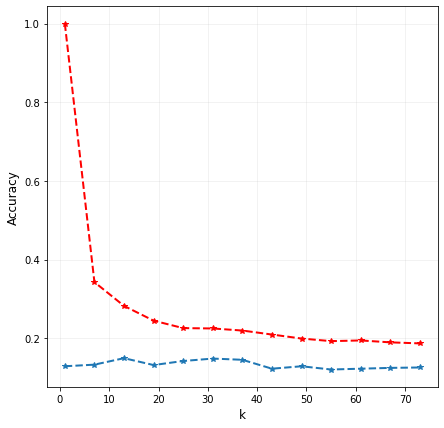

In [ ]:
from google.colab import widgets
from sklearn import neighbors
from matplotlib.colors import ListedColormap

k_values = range(1,75,6)

accuracy_t = dict.fromkeys(k_values)
accuracy_v = dict.fromkeys(k_values)

for k in k_values:

  # First we create the kNN model
  knn = neighbors.KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train, y_train)

  # Finally we calculate the validation accuracy
  y_val_pred = knn.predict(X_val)
  accuracy_v[k] = np.sum(y_val==y_val_pred)/len(y_val)

  # Training accuracy
  y_train_pred = knn.predict(X_train)
  accuracy_t[k] = np.sum(y_train==y_train_pred)/len(y_train)

# Here we predict the value of the validation accuracy as a function of k
plt.figure(figsize=(7, 7))
plt.plot(k_values, list(accuracy_v.values()), '--*', linewidth=2)
plt.plot(k_values, list(accuracy_t.values()), '--*', linewidth=2, color='red')
plt.xlabel("k", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.grid(alpha=0.2)
plt.show()

# **result**
as we see in the graph it seems this method is not suitable for our situation(problem and dataset), the accuracy of validation is less than 0.2 for all k values, even we dont have a high accuracy in train samples, lets try another methods and see the result

# **model selection**
In this section, we use the k-fold cross-validation method to split our samples to train and validate then we create 5 different classifiers separately (SVM, DecisionTree, RandomForest, GradientBoostingClassifier, LogisticRegression) to model our data and compare the accuracy of them. 

the train and validation accuracy of each type of classifier is placed in the comments below it. the train acc of random forest is 0.6809434350825921 and validation acc is 0.34507280589170025 so we dont have overfitting or underfitting.
the result is that the random forest has higher accuracy in comparison to 4 other classifiers. so we choose this method as our classifier


In [ ]:
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression


#kfold params
random_state = 12883823
rkf = RepeatedKFold(n_splits=8, n_repeats=2, random_state=random_state)
train_acc = []
val_acc = []

epoch = 0
for train, test in rkf.split(X):

  epoch = epoch + 1
  print("epoch number {}".format(epoch))

  X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]

  #normalize features
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_val_scaled = scaler.transform(X_test)

  #SVM
  #model = svm.SVC(C=1,gamma=2,probability=True)
  #train_acc 0.5933186026621278
  #val_acc 0.3029049779977998

  #DecisionTree
  #model = tree.DecisionTreeClassifier(min_samples_split=150)
  #train_acc 0.35877495588962605
  #val_acc 0.3072290215132624

  #RandomForest
  model = RandomForestClassifier(max_depth=8, random_state=1)
  #train_acc 0.6809434350825921
  #val_acc 0.34507280589170025

  #GradientBoostingClassifier
  #model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
  #train_acc 0.42190754682505016
  #val_acc 0.32205453184207306

  #LogisticRegression
  #model = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')
  #train_acc 0.24661248157809196
  #val_acc 0.23478639530619727
  
  model.fit(X_train_scaled,y_train)

  yt_p = model.predict(X_train_scaled)
  yv_p = model.predict(X_val_scaled)

  train_acc.append(np.mean(yt_p==y_train))
  val_acc.append(np.mean(yv_p==y_test))

print('train_acc',sum(train_acc)/len(train_acc))
print('val_acc',sum(val_acc)/len(val_acc))

epoch number 1
epoch number 2
epoch number 3
epoch number 4
epoch number 5
epoch number 6
epoch number 7
epoch number 8
epoch number 9
epoch number 10
epoch number 11
epoch number 12
epoch number 13
epoch number 14
epoch number 15
epoch number 16
train_acc 0.6809434350825921
val_acc 0.34507280589170025


# **ROC**
now we select the random forest as our classifier based on accuracy, we also want to evaluate the result of this selected classifier by the ROC method. ROC method is suitable for binary classification problems so we should make our multi-class problem suitable to evaluate with ROC. for this purpose we should implement the one vs all classification approach. in this approach, the samples are classified as label x or label y, in which label x is one of our class labels and label y points to all other class labels except x.

In [ ]:
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

#load features and lables from file that we stored before
X= np.load('X.npy')
y= np.load('y.npy')

#we should binarize the lables as one label vs all other labels
y = label_binarize(y, classes=list(digit_labels.values()))
n_classes = y.shape[1]

#split the data to train and test
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

#normalize data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

#define one vs all classifier
# Learn to predict each class against the other
#RandomForest
classifier = OneVsRestClassifier(RandomForestClassifier(max_depth=8, random_state=1))
classifier.fit(X_train_scaled, y_train)
y_score = classifier.predict_proba(X_val_scaled)

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 8
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

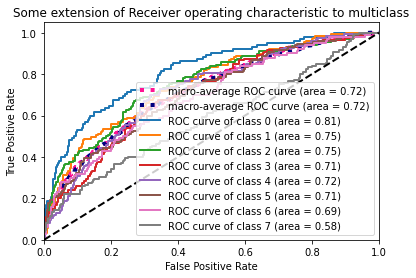

In [ ]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)
lw = 2
#colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


# **result**
we can see that all classifire for each label are above the random classifier. if we take a look at the curve area of each classifier(for each label) we can see that the random area is 0.72 and half of the classifiers area are more than this value.

# 9 Conclusions
we have some doubts about the correctness of our data, some songs may not be the same as their name or some audio files may empty records so we have the outlier in our data which will cause misclassification and there is no easy way to get rid of these kinds of samples. 

**Improvement**

- For improvement, the easiest way is to tune the parameters of the classifier 
and find the one which brings high accuracy for our trained model. 

- also, we can take a look at the confusion matrix and find out some misclassified songs then listen to each song and compare it to the song which is belonged to the class that the model assign to the first song wrongly to find out what is the problem we may find a solution for it by add/remove one feature to our samples.

- another suggestion is, they are some organized and trustable hum/whistle datasets that we can use alongside our own dataset

# **Test**
Lets have some fun and see if our model can predict the unseen samples of hum/whisle of myself correct.
I have my own whisle/hum audio files, and I find the random id that assigned to me in demographic data that published recently. it is s271, so I should search it in our dataset information and check if it is exist or not. 

In [ ]:
MLENDHW_df[MLENDHW_df['participant'].str.contains("s271")]

,participant,interpretation,number,song
file_id,,,,


hopefully, it is not exit in our train/val data. so we can use it as a test data. we should extract the feature from our audios and normalise them and finally pass them to our previous trained model. and see the classification result

In [ ]:
X_unseen= np.load('X_unseen.npy')
y_unseen= np.load('y_unseen.npy')
print(X_unseen.shape,'X')
print(y_unseen.shape, 'y')

(32, 5) X
(32,) y


In [ ]:
from pandas.compat import numpy
#normalize data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_unseen_scaled = scaler.fit_transform(X_unseen)

#RandomForest
y_p_unseen = model.predict(X_unseen_scaled)
result = np.column_stack([y_unseen,y_p_unseen])
print(result.shape)
print(result.T)
print('actual y',[list(digit_labels.keys())[list(digit_labels.values()).index(x)] for x in y_unseen])
print('predicted y',[list(digit_labels.keys())[list(digit_labels.values()).index(x)] for x in y_p_unseen])
print('acc is {}'.format(np.mean(y_p_unseen==y_unseen)))

(32, 2)
[[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
 [4 2 2 1 4 3 1 1 0 5 0 0 2 2 1 1 1 2 0 2 2 0 2 1 4 0 2 2 0 4 0 0]]
actual y ['potter', 'potter', 'potter', 'potter', 'potter', 'potter', 'potter', 'potter', 'potter', 'potter', 'potter', 'potter', 'potter', 'potter', 'potter', 'potter', 'potter', 'potter', 'potter', 'potter', 'potter', 'potter', 'potter', 'potter', 'potter', 'potter', 'potter', 'potter', 'potter', 'potter', 'potter', 'potter']
predicted y ['potter', 'mamma', 'mamma', 'hakuna', 'potter', 'panther', 'hakuna', 'hakuna', 'frozen', 'rain', 'frozen', 'frozen', 'mamma', 'mamma', 'hakuna', 'hakuna', 'hakuna', 'mamma', 'frozen', 'mamma', 'mamma', 'frozen', 'mamma', 'hakuna', 'potter', 'frozen', 'mamma', 'mamma', 'frozen', 'potter', 'frozen', 'frozen']
acc is 0.125
